# <center>金融計算程式運用期末報告
## **<center >選擇權隱含波動度之計算與選擇權價格預測**
### <center>財管五 105307030 陳韋勳

In [1]:
import pandas as pd
import datetime
import numpy as np
from math import log,sqrt,exp
from scipy import stats
import matplotlib.pyplot as plt

## 1. 資料清理 
對台指選擇權、台指期、加權指數逐筆交易資料做清理，並整理成5分K格式

### -台指選擇權資料-

In [2]:
# 匯入交易所選擇權逐筆交易資料
optionData=pd.read_fwf('OptionsDaily_2020_12_15.rpt',delimiter =' ,')
print('原始逐筆資料: ')
optionData.head()

原始逐筆資料: 


,成交日期,Unnamed: 1,商品代號,Unnamed: 3,履約價格,Unnamed: 5,到期月份(週別),買賣權別,成交時間,成交價格,成交數量(B,or,S),開盤集合競價
0,----------,----,-------,----,----------------------------------------------...,----,------- ----,----- ----,---------,---- --------,---- ---------,NaN,NaN,NaN
1,20201215,NaN,CBO,NaN,24,NaN,202101,P,130740,.25,1,NaN,NaN,NaN
2,20201215,NaN,CBO,NaN,24,NaN,202101,P,130740,.25,1,NaN,NaN,NaN
3,20201215,NaN,CBO,NaN,24,NaN,202101,P,130931,.36,2,NaN,NaN,NaN
4,20201215,NaN,CBO,NaN,24,NaN,202101,P,130931,.36,2,NaN,NaN,NaN


 清理步驟: 
* 將空白行刪除
* 從商品代號中取出TXO
* 從買賣權別取出C
* 從到期月份取出交易量最大的(202012)
* 從履約價格中取出交易量大的(14200)
* 刪除錯誤資料

In [3]:
# 找出交易量大的到期月份及履約價格
print(optionData['到期月份(週別)'].value_counts().head())   #選202012
print(optionData['履約價格'].value_counts().head())        #選14200

202012    465187
202101     31117
202106       959
202102       890
202103       517
Name: 到期月份(週別), dtype: int64
14200    82649
14100    78440
14150    71169
14250    47588
14050    40803
Name: 履約價格, dtype: int64


In [4]:
# 將空白欄位刪除
optionData=optionData.drop(
    columns=['Unnamed: 1', 'Unnamed: 3', 'Unnamed: 5', 'or', 'S)', '開盤集合競價'],index=0)

#選取台指選/買權/交易量最大的到期月份/選取開盤時交易量大的商品
optionData = optionData[optionData['商品代號']=='TXO']
optionData=optionData[optionData['買賣權別']=='C']
optionData=optionData[optionData['到期月份(週別)']=='202012']
optionData=optionData[optionData['履約價格']=='14200']

#重新命名欄位
optionData=optionData.rename(columns={'成交日期':'Date','成交時間':'Time','成交價格':'Price','成交數量(B':'Volume'})

#刪除錯誤資料
optionData= optionData.drop(index=[272470,272471])  

optionData['Price']=pd.to_numeric(optionData['Price'])
optionData['Volume']=pd.to_numeric(optionData['Volume'])
optionData=optionData.reset_index(drop=True)

In [5]:
# 將逐筆資料轉成五分鐘累計資料，其中包括開盤價/最高價/最低價/收盤價/交易量
def mto5m_raw(x):
    x['Date']=x['Date']+' '+x['Time']
    x=x.drop(columns='Time')
    x['Date']=pd.to_datetime(x['Date'],format='%Y%m%d %H:%M:%S')
    
    #取出開高低收價&交易量並合併
    Open=x.groupby(pd.Grouper(freq='5T',key='Date',label='right',closed='right'))['Price'].first()
    High=x.groupby(pd.Grouper(freq='5T',key='Date',label='right',closed='right'))['Price'].max()
    Low=x.groupby(pd.Grouper(freq='5T',key='Date',label='right',closed='right'))['Price'].min()
    Close=x.groupby(pd.Grouper(freq='5T',key='Date',label='right',closed='right'))['Price'].last()
    Volume=x.groupby(pd.Grouper(freq='5T',key='Date',label='right',closed='right'))['Volume'].sum()
    newdata=pd.concat([Open,High,Low,Close,Volume],axis=1,names=['Open','High','Low','Close','Volume'])
    
    newdata.reset_index(inplace=True)
    newdata=newdata.dropna()
    newdata.columns=['Date','Open','High','Low','Close','Volume']
    
    return newdata

# 將已經處理過的資料轉成5分鐘，其中包括開盤價/最高價/最低價/收盤價/交易量
def mto5m_new(x):
    x['Date']=pd.to_datetime(x['Date'],format='%Y%m%d %H:%M:%S')
    
    #取出開高低收價&交易量並合併
    Open=x.groupby(pd.Grouper(freq='5T',key='Date',label='right',closed='right'))['Price'].first()
    High=x.groupby(pd.Grouper(freq='5T',key='Date',label='right',closed='right'))['Price'].max()
    Low=x.groupby(pd.Grouper(freq='5T',key='Date',label='right',closed='right'))['Price'].min()
    Close=x.groupby(pd.Grouper(freq='5T',key='Date',label='right',closed='right'))['Price'].last()
    
    newdata=pd.concat([Open,High,Low,Close],axis=1,names=['Open','High','Low','Close'])
    
    newdata.reset_index(inplace=True)
    newdata=newdata.dropna()
    newdata.columns=['Date','Open','High','Low','Close']
    
    return newdata

In [6]:
option=mto5m_raw(optionData)

In [7]:
print('整理後的5分K台指選資料: ')
option.columns=['Date', 'OOpen', 'OHigh', 'OLow', 'OClose', 'OVolume']
option.head()

整理後的5分台指選資料: 


,Date,OOpen,OHigh,OLow,OClose,OVolume
0,2020-12-14 15:00:00,60.0,60.0,60.0,60.0,2
1,2020-12-14 15:05:00,55.0,66.0,55.0,63.0,1270
2,2020-12-14 15:10:00,63.0,70.0,63.0,70.0,316
3,2020-12-14 15:15:00,70.0,70.0,64.0,67.0,220
4,2020-12-14 15:20:00,67.0,70.0,66.0,66.0,266


### -台指期資料-

In [8]:
TX=pd.read_fwf('Daily_2020_12_15.rpt',delimiter =' ,')
TX.head()

,"成交日期,商品代號,到期月份(週別),成交時間",成交價格,"成交數量(B+S),近月價格,遠月價格,開盤集合競價"
0,"20201214,BRF ,202102",NaN,"225330,1402,2,-,-"
1,"20201214,BRF ,202102",NaN,"233837,1399.5,4,-,-"
2,"20201214,BRF ,202102",NaN,"235255,1395,4,-,-"
3,"20201214,BRF ,202102",NaN,"235311,1393.5,6,-,-"
4,"20201215,BRF ,202102",NaN,"000036,1385.5,4,-,-"


清理步驟: 
* 將擠在同一行的資料分離
* 刪除空白行
* 取出台指選
* 取出特定資料

In [9]:
#分離第二行
a=TX['成交日期,商品代號,到期月份(週別),成交時間'].str.split(',', 2, expand=True)
TX['Date']=a[0]
TX['Symbol']=a[1]
TX['Maturity']=a[2]

#分離第四行
b=TX['成交數量(B+S),近月價格,遠月價格,開盤集合競價'].str.split(',', 3, expand=True)
TX['Time']=b[0]
TX['Price']=b[1]
TX['Volume']=b[2]

#刪除空白行
TX= TX.drop(columns=['成交日期,商品代號,到期月份(週別),成交時間','成交價格','成交數量(B+S),近月價格,遠月價格,開盤集合競價'])

#取出特定資料
TX = TX[TX['Symbol']=='TX     ']
TX= TX[TX['Maturity']=='202012']
TX['Volume']=pd.to_numeric(TX['Volume'],errors='raise')
TX=TX[TX['Volume']>=0]

TX['Time']=TX['Time'].str[0:2]+':'+TX['Time'].str[2:4]+':'+TX['Time'].str[4:6]


In [10]:
TX=mto5m_raw(TX)
TX.head()

,Date,Open,High,Low,Close,Volume
0,2020-12-14 15:00:00,14192,14192,14179,14185,350
1,2020-12-14 15:05:00,14178,14200,14171,14193,2742
2,2020-12-14 15:10:00,14193,14208,14191,14207,864
3,2020-12-14 15:15:00,14208,14209,14194,14201,642
4,2020-12-14 15:20:00,14201,14207,14199,14200,776


### -台灣加權指數-

In [124]:
Twse= pd.read_csv('Twse.csv', header=None)
Twse.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,09:00:00,14211.05,12457.72,15218.86,13025.31,169.72,1694.08,244.74,522.80,223.78,...,136.73,127.21,85.62,337.42,84.57,99.36,1261.00,248.83,123.03,304.00
1,09:00:05,14206.33,12453.40,15216.37,13023.44,169.71,1693.48,243.64,523.15,223.39,...,136.73,127.31,85.94,337.41,85.08,99.35,1260.73,248.91,123.03,304.22
2,09:00:10,14213.14,12462.45,15209.85,13024.21,169.58,1693.51,243.75,523.29,223.41,...,136.75,127.34,85.88,337.26,85.06,99.22,1258.71,248.66,123.03,304.23
3,09:00:15,14199.99,12449.46,15204.73,13017.65,169.84,1693.63,243.73,523.38,223.47,...,136.63,127.34,85.90,337.47,85.21,99.22,1258.80,248.52,122.07,304.54
4,09:00:20,14210.44,12460.50,15202.37,13017.67,169.67,1692.72,243.66,523.28,223.54,...,136.38,127.24,86.02,337.57,85.36,99.21,1258.12,248.36,122.07,304.52


In [125]:
Twse= Twse.drop(columns=[2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34])

Twse.columns=['Date', 'Price']
Twse['Date']= '2020-12-15'+' '+ Twse['Date']

Twse= mto5m_new(Twse)
Twse.head()

,Date,Open,High,Low,Close
0,2020-12-15 09:00:00,14211.05,14211.05,14211.05,14211.05
1,2020-12-15 09:05:00,14206.33,14231.57,14198.99,14230.00
2,2020-12-15 09:10:00,14220.84,14232.72,14211.02,14231.75
3,2020-12-15 09:15:00,14232.00,14255.59,14223.32,14255.59
4,2020-12-15 09:20:00,14249.60,14256.55,14236.31,14246.35


## 2. 計算隱含波動度

### 整理計算隱含波動度所需要的資料( S / C / K / r / T ) 

In [116]:
#將前面整理好的五分K選擇權和加權指數的資料合併
calData= pd.merge(option,Twse,how='left',on='Date')

calData= calData.drop(columns=['OOpen', 'OHigh', 'OLow','OVolume','Open', 'High', 'Low'])
calData= calData.dropna()

calData.columns=['Date','Call','Stock']

calData['Stock']=pd.to_numeric(calData['Stock'])
calData['Call']=pd.to_numeric(calData['Call'])
calData= calData.set_index('Date')

In [117]:
k=14200
r=0.0032
t=2/365

In [118]:
#根據BS公式計算期權價值
def bsm_call_value(s0,k,t,r,sigma):
    d1 = ( log( s0/k ) + ( r + 0.5*sigma**2 )*t )/( sigma*sqrt(t) )
    d2 = ( log( s0/k ) + ( r - 0.5*sigma**2 )*t )/( sigma*sqrt(t) )
    value = ( s0*stats.norm.cdf( d1,0.,1. ) - k*exp( -r*t )*stats.norm.cdf( d2,0.,1 ))
    return value

bsm_call_value=np.vectorize(bsm_call_value)

#二分法求隱含波動率
def bsm_imp_vol(s,k,t,r,c):
    c_est = 0      # 期權價格估計值
    top = 1        # 波動率上限
    floor = 0      # 波動率下限
    sigma = ( floor + top )/2    #波動率初始值
    count = 0 # 計數器
    while abs( c - c_est ) > 0.000001:
        c_est = bsm_call_value(s,k,t,r,sigma) 
        # 根據價格判斷波動率是被低估還是高估，並對波動率做修正
        count += 1           
        if count > 100: # 時間價值為0的期權是算不出隱含波動率的，因此迭代到一定次數就不再迭代了
            sigma = 0
            break
        
        if c - c_est > 0: #f (x)>0
            floor = sigma
            sigma = ( sigma + top )/2
        else:
            top = sigma
            sigma = ( sigma + floor )/2
    return sigma  

bsm_imp_vol=np.vectorize(bsm_imp_vol)


In [119]:
#計算隱含波動度
impliedV= bsm_imp_vol(calData['Stock'],k,t,r,calData['Call'])
calData['impliedV']=impliedV
calData.head()

,Call,Stock,impliedV
Date,,,
2020-12-15 09:00:00,44.5,14211.05,0.091985
2020-12-15 09:05:00,51.0,14230.00,0.080376
2020-12-15 09:10:00,58.0,14231.75,0.095234
2020-12-15 09:15:00,72.0,14255.59,0.089683
2020-12-15 09:20:00,66.0,14246.35,0.091120


Text(0,0.5,'Implied Volatility')

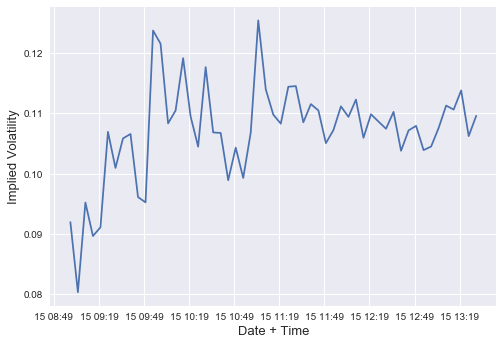

In [120]:
#繪製出隱含波動度圖形
plt.style.use('seaborn')
plt.plot(calData['impliedV'])

plt.xlabel('Date + Time',fontsize=13)
plt.ylabel('Implied Volatility',fontsize=13)

## 3. 估計選擇權價格
### -假設短期波動度不變，運用前一5分K的隱含波動度做為未來預估值，用BS計算選擇權價格

In [121]:
calData['eximpliedV']= calData['impliedV'].shift(1)
calData= calData.dropna()
calData['predictCall']= bsm_call_value(calData['Stock'],k,t,r,calData['eximpliedV'])
calData.head()

,Call,Stock,impliedV,eximpliedV,predictCall
Date,,,,,
2020-12-15 09:05:00,51.0,14230.00,0.080376,0.091985,55.608254
2020-12-15 09:10:00,58.0,14231.75,0.095234,0.080376,52.128159
2020-12-15 09:15:00,72.0,14255.59,0.089683,0.095234,73.978225
2020-12-15 09:20:00,66.0,14246.35,0.091120,0.089683,65.464718
2020-12-15 09:25:00,63.0,14232.24,0.106947,0.091120,56.672777


### -預估價格與真實價格做比較

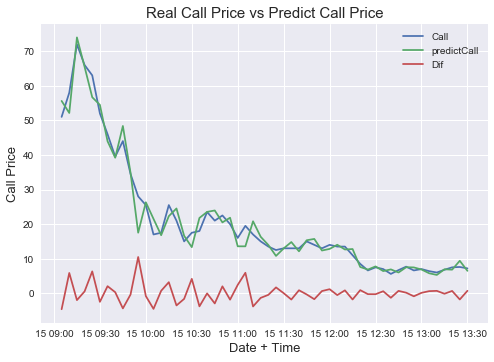

In [129]:
calData['Dif']= calData['Call']- calData['predictCall']
plt.plot(calData['Call'])
plt.plot(calData['predictCall'])
plt.plot(calData['Dif'])

plt.title('Real Call Price vs Predict Call Price',fontsize=15)
plt.xlabel('Date + Time',fontsize=13)
plt.ylabel('Call Price',fontsize=13)
plt.legend(loc = 'upper right')

## 4. 結論與改進
### 結論
實證前，因為隱含波動度為市場對未來波動度的預期，
<br>所以認為短期內，如果沒有太大的消息出現，隱含波動度應該不會有太劇烈變化，
<br>並想藉前一期計算出的隱含波動度，去估計下一期的選擇權價格。
<br><br>但實證後，發現隱含波動度"可能有"劇烈變化，這樣會影響最初的假設，使價格預測變無效
<br>
### 改進
<br>但由於目前採用資料過少，可以嘗試增加資料長度，
<br>並嘗試去用一段時間的隱含波動度的平均值做為估計，以避免採用偏誤的隱含波動度
